In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr as hagan2002
import yfinance as yf
import datetime

def call_value(S, K, sigma, t=0, r=0):
    # use np.multiply and divide to handle divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

def call_vega(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(t)

def bs_iv(price, S, K, t=0, r=0, precision=1e-4, initial_guess=0.2, max_iter=1000, verbose=False):
    iv = initial_guess
    for _ in range(max_iter):
        P = call_value(S, K, iv, t, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, t, r)
        iv += diff/grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    return iv 

def plot_vol_smile(calls, savefig=False):
    plt.figure(figsize=(9,6))
    plt.plot(calls.strike, calls.iv, ".")
    plt.xlabel("Strike")
    plt.ylabel("IV")
    if savefig:
        plt.savefig("vol_smile.png",dpi=300)
    plt.show()
    
def pdf2(Krange, vol_surface, S, t, r=0):
    # x is a range of strikes
    Crange = call_value(S, Krange, vol_surface, t, r)
    first_deriv = np.gradient(Crange, Krange)
    second_deriv = np.gradient(first_deriv, Krange)
    return np.exp(r * t) * second_deriv

def pfd(ticker,date_index=0,Kfac=1):
    stock = yf.Ticker(ticker)
    S = stock.fast_info['lastPrice']
    
    exp = stock.options[date_index]
    
    t1 = datetime.date.fromisoformat(exp) 
    t2= datetime.date.today()
    t= (t1-t2).days/7/52
    
    opt = stock.option_chain(exp)
    calls = opt.calls
    calls['midprice'] = (calls['bid'] + calls['ask'])/2
    calls["iv"] = calls.apply(lambda row: bs_iv(row.midprice, S, row.strike, t, max_iter=1000,initial_guess=row.impliedVolatility), axis=1)
    calls_no_na = calls.dropna()
    
    beta=0.5
    sabr = Hagan2002LognormalSABR(f=S, shift=0, t=t, beta=beta)
    [alpha, rho, volvol] = sabr.fit(calls_no_na.strike, calls_no_na.iv*100)

    strikes = np.arange(calls.strike.min()/Kfac, calls.strike.max()*Kfac, 0.1)

    vol_surface = []
    for strike in strikes:
        vol_surface.append(hagan2002.lognormal_vol(strike, f=S, t=t, alpha=alpha, beta=beta, rho=rho, volvol=volvol))

    C_interp = call_value(S, strikes, np.array(vol_surface), t)
    pdf = pdf2(strikes,np.array(vol_surface),S, t)
    return calls_no_na,strikes,C_interp,np.array(vol_surface),pdf 

def get_calls(ticker,date_index=0):
    stock = yf.Ticker(ticker)
    S = stock.fast_info['lastPrice']
    
    exp = stock.options[date_index]
    
    t1 = datetime.date.fromisoformat(exp) 
    t2= datetime.date.today()
    t= (t1-t2).days/7/52
    
    opt = stock.option_chain(exp)
    calls = opt.calls
    calls['midprice'] = (calls['bid'] + calls['ask'])/2
    calls["iv"] = calls.apply(lambda row: bs_iv(row.midprice, S, row.strike, t, max_iter=1000,initial_guess=row.impliedVolatility), axis=1)
    calls_no_na = calls.dropna()
    return calls_no_na,t,S,exp

def vol_extrap(ticker,date_index=0,t2=1,Kfac=1):
    [calls,t1,S,exp] = get_calls(ticker,date_index=date_index)
    print(t1)

    beta=0.5
    sabr = Hagan2002LognormalSABR(f=S, shift=0, t=t1, beta=beta)
    [alpha, rho, volvol] = sabr.fit(calls.strike, calls.iv*100)

    strikes = np.arange(calls.strike.min()/Kfac, calls.strike.max()*Kfac, 0.1)
    
    vol_surface_t1 = []
    for strike in strikes:
        vol_surface_t1.append(hagan2002.lognormal_vol(strike, f=S, t=t1, alpha=alpha, beta=beta, rho=rho, volvol=volvol))
     
    vol_surface_t2 = []
    for strike in strikes:
        vol_surface_t2.append(hagan2002.lognormal_vol(strike, f=S, t=t2, alpha=alpha, beta=beta, rho=rho, volvol=volvol))
        
    plt.figure(figsize=(9,6))
    plt.plot(calls.strike, calls.iv, "bx", strikes, vol_surface_t1, "k-",strikes, vol_surface_t2, "k--");
    plt.legend(["Implied Vol", "fitted smile "+exp], loc="best")

    plt.xlabel("Strike")
    plt.ylabel("IV")
    plt.tight_layout()
    exp = stock.options[i]
    plt.title("underlying stock:"+ticker+", options expiration:"+exp)
    plt.show()


In [6]:
ticker='frg'
stock = yf.Ticker(ticker)
print(stock.options)

('2023-04-21', '2023-05-19', '2023-06-16', '2023-08-18', '2023-09-15', '2023-11-17', '2024-01-19', '2024-06-21')


In [7]:
i=3
[calls,strikes,C_interp,vol_surface,pdf] = pfd(ticker=ticker,date_index=i,Kfac=2)
print(np.sum(pdf*strikes*0.1))

27.597326097948255


C:\Users\z003eb4h\AppData\Local\Temp\ipykernel_18052\2556258915.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
C:\Users\z003eb4h\AppData\Local\Temp\ipykernel_18052\2556258915.py:15: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\z003eb4h\AppData\Local\Temp\ipykernel_18052\2556258915.py:21: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)


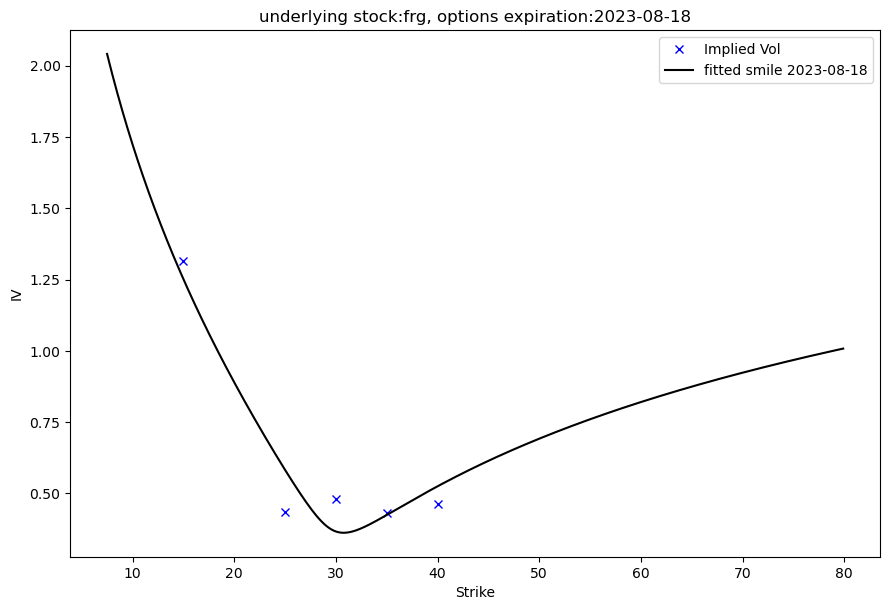

In [8]:
plt.figure(figsize=(9,6))
exp = stock.options[i]
plt.plot(calls.strike, calls.iv, "bx", strikes, vol_surface, "k-");
plt.legend(["Implied Vol", "fitted smile "+exp], loc="best")

plt.xlabel("Strike")
plt.ylabel("IV")
plt.tight_layout()

plt.title("underlying stock:"+ticker+", options expiration:"+exp)
plt.show()

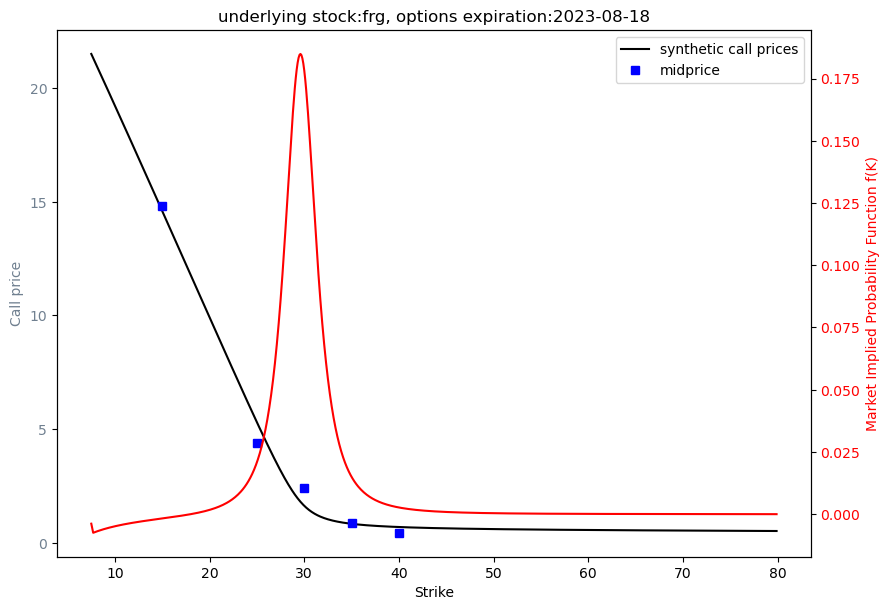

       contractSymbol             lastTradeDate  strike  lastPrice   bid  \
0  FRG230818C00015000 2023-01-20 19:22:22+00:00    15.0      14.51  13.9   
2  FRG230818C00025000 2023-03-14 16:40:59+00:00    25.0       3.64   2.0   
3  FRG230818C00030000 2023-02-28 17:54:05+00:00    30.0       2.60   0.0   
4  FRG230818C00035000 2023-03-20 17:45:59+00:00    35.0       0.55   0.0   
5  FRG230818C00040000 2023-03-31 15:10:48+00:00    40.0       0.30   0.3   

     ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  15.70    0.00        0.00000       2             2           1.310550   
2   6.80    0.00        0.00000       2            29           0.822756   
3   4.80    0.00        0.00000       5             8           0.828127   
4   1.75    0.00        0.00000      81            84           0.580815   
5   0.60   -0.27      -47.36842       1           321           0.499028   

   inTheMoney contractSize currency  midprice        iv  
0        True      REGULAR  

In [9]:
fig, ax1 = plt.subplots(figsize=(9,6))

col="slategrey"
ax1.set_xlabel('Strike')
ax1.set_ylabel('Call price', color=col)
ax1.plot(strikes, C_interp, "k-", calls.strike, calls.midprice, "bs")
ax1.tick_params(axis='y', labelcolor=col)
ax1.legend(["synthetic call prices", "midprice"], loc="best")

ax2 = ax1.twinx()
col = 'red'
ax2.set_ylabel('Market Implied Probability Function f(K)', color=col)
ax2.plot(strikes, pdf, color=col)
ax2.tick_params(axis='y', labelcolor=col)

# ax2 = ax1.twinx()
# col = 'red'
# ax2.set_ylabel('Market Implied Probability Function f(K)', color=col)
# ax2.plot(strikes, pdf2(strikes,np.array(vol_surface),S, t), color=col)
# ax2.tick_params(axis='y', labelcolor=col)

# ax3 = ax1.twinx()
# col = 'blue'
# ax3.set_ylabel('f(K)', color=col)
# ax3.plot(strikes,np.gradient(C_interp, strikes), color=col)
# ax3.tick_params(axis='y', labelcolor=col)

fig.tight_layout()
exp = stock.options[i]
ax1.set_title("underlying stock:"+ticker+", options expiration:"+exp)
plt.show()

print(calls)

In [56]:
print(calls['midprice'])
print(calls['strike'])

0    10.800
1     7.500
2     5.150
3     3.400
4     2.300
5     1.725
Name: midprice, dtype: float64
0    15.0
1    20.0
2    25.0
3    30.0
4    35.0
5    40.0
Name: strike, dtype: float64


C:\Users\z003eb4h\AppData\Local\Temp\ipykernel_12012\2556258915.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
C:\Users\z003eb4h\AppData\Local\Temp\ipykernel_12012\2556258915.py:15: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\z003eb4h\AppData\Local\Temp\ipykernel_12012\2556258915.py:21: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\z003eb4h\AppData\Local\Temp\ipykernel_12012\2556258915.py:15: RuntimeWarning: overflow encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\z003eb4h\AppData\Local\Temp\ipykernel_12012\2556258915.py:21: RuntimeWarning: overflow encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\z003eb4h\Ap

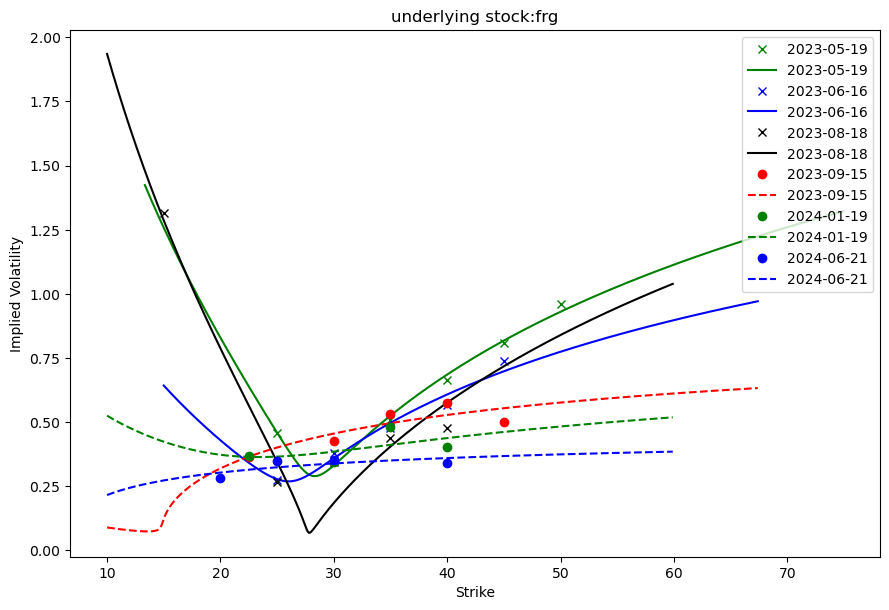

In [29]:
ticker='frg'
stock = yf.Ticker(ticker)
plt.figure(figsize=(9,6))
sym=['rx','gx','bx','kx','ro','go','bo','ko','rs','gs','bs','ks','rd','gd','bd','kd','r*','g*','b*','k*']
lin=['r-','g-','b-','k-','r--','g--','b--','k--','r-.','g-.','b-.','k-.','r-','g-','b-','k-','r:','g:','b:','k:']

for i in range(1,len(stock.options)):
    exp = stock.options[i]
    [calls,strikes,C_interp,vol_surface,pdf] = pfd(ticker=ticker,date_index=i,Kfac=1.5)
    plt.plot(calls.strike, calls.iv, sym[i], strikes, vol_surface, lin[i],label=exp);
    

#plt.legend(["Implied Vol", "fitted smile "+exp], loc="best")
plt.legend(loc='upper right')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.tight_layout()

plt.title("underlying stock:"+ticker)
plt.show()

17.7
17.13
14.83


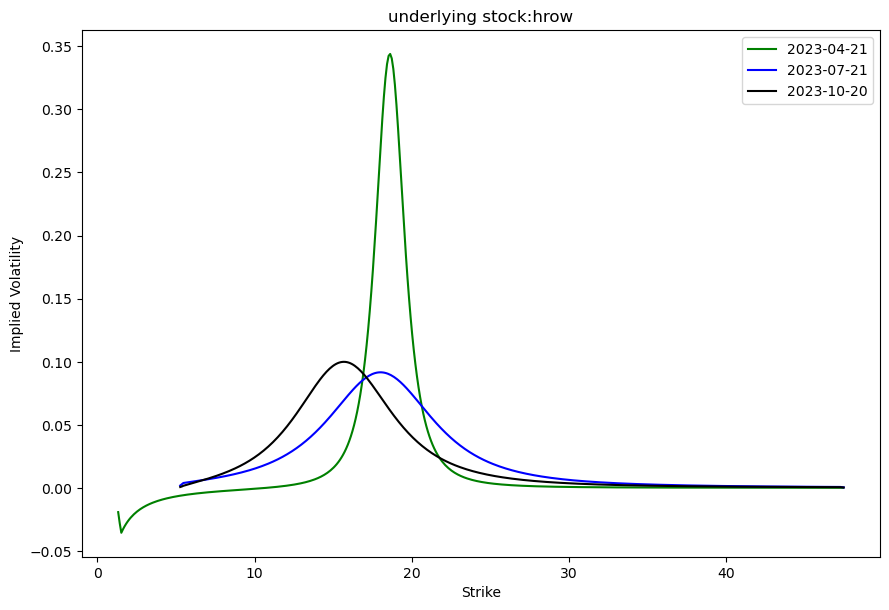

In [25]:
ticker='hrow'
stock = yf.Ticker(ticker)
plt.figure(figsize=(9,6))
sym=['rx','gx','bx','kx','ro','go','bo','ko','rs','gs','bs','ks','rd','gd','bd','kd','r*','g*','b*','k*']
lin=['r-','g-','b-','k-','r--','g--','b--','k--','r-.','g-.','b-.','k-.','r-','g-','b-','k-','r:','g:','b:','k:']

for i in range(1,len(stock.options)):
#for i in range(10,20):
    exp = stock.options[i]
    [calls,strikes,C_interp,vol_surface,pdf] = pfd(ticker=ticker,date_index=i,Kfac=1.9)
    plt.plot(strikes, pdf, lin[i],label=exp);
    print(round(np.sum(pdf*strikes*0.1),2))
    
#plt.legend(["Implied Vol", "fitted smile "+exp], loc="best")
plt.legend(loc='upper right')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.tight_layout()

plt.title("underlying stock:"+ticker)
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(9,6))

col="slategrey"
ax1.set_xlabel('Strike')
ax1.set_ylabel('Call price', color=col)
ax1.plot(strikes, C_interp, "k-", calls.strike, calls.midprice, "bs")
ax1.tick_params(axis='y', labelcolor=col)
ax1.legend(["synthetic call prices", "midprice"], loc="best")

ax2 = ax1.twinx()
col = 'red'
ax2.set_ylabel('Market Implied Probability Function f(K)', color=col)
ax2.plot(strikes, pdf, color=col)
ax2.tick_params(axis='y', labelcolor=col)

# ax2 = ax1.twinx()
# col = 'red'
# ax2.set_ylabel('Market Implied Probability Function f(K)', color=col)
# ax2.plot(strikes, pdf2(strikes,np.array(vol_surface),S, t), color=col)
# ax2.tick_params(axis='y', labelcolor=col)

# ax3 = ax1.twinx()
# col = 'blue'
# ax3.set_ylabel('f(K)', color=col)
# ax3.plot(strikes,np.gradient(C_interp, strikes), color=col)
# ax3.tick_params(axis='y', labelcolor=col)

fig.tight_layout()
exp = stock.options[i]
ax1.set_title("underlying stock:"+ticker+", options expiration:"+exp)
plt.show()

In [ ]:
beta=0.5
calls_no_na = calls.dropna()
sabr = Hagan2002LognormalSABR(f=S, shift=0, t=t, beta=beta)
[alpha, rho, volvol] = sabr.fit(calls_no_na.strike, calls_no_na.iv*100)

strikes = np.arange(calls.strike.min()/Kfac, calls.strike.max()*Kfac, 0.1)
vol_surface = []
for strike in strikes:
    vol_surface.append(hagan2002.lognormal_vol(strike, f=S, t=t, alpha=alpha, beta=beta, rho=rho, volvol=volvol))
    
#C_interp = call_value(S, x_new, vol_surface(x_new), t)
C_interp = call_value(S, strikes, np.array(vol_surface), t)

In [ ]:
t1 = datetime.date.fromisoformat(exp) 
t2= datetime.date.today()
t= (t1-t2).days/7/52
opt = stock.option_chain(exp)
calls = opt.calls
calls['midprice'] = (calls['bid'] + calls['ask'])/2
calls["iv"] = calls.apply(lambda row: bs_iv(row.midprice, S, row.strike, t, max_iter=1000,initial_guess=row.impliedVolatility), axis=1)

print(calls.head())

In [ ]:
Kfac=1.9

In [ ]:
print(pdf2(strikes,np.array(vol_surface),S, t).sum()*0.1)

0.04120879120879121


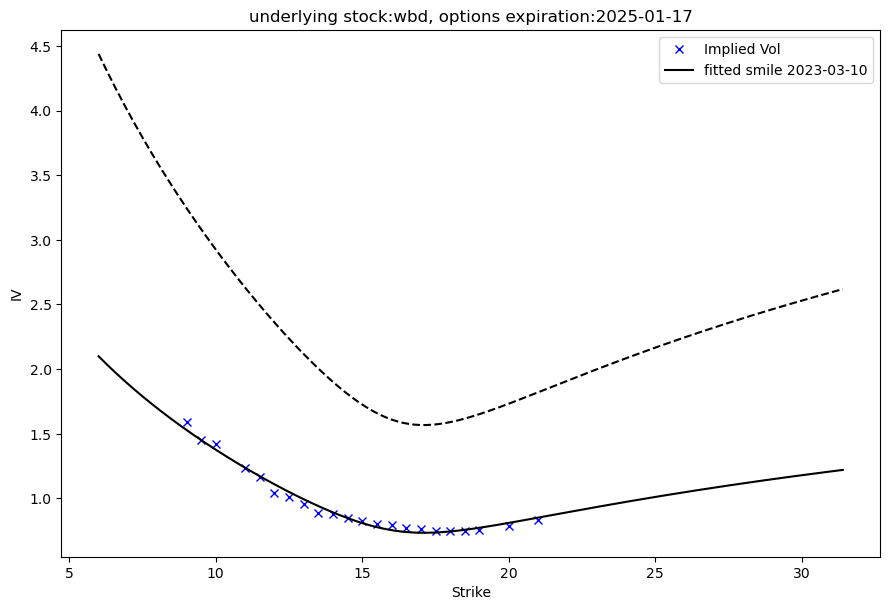

In [9]:
vol_extrap(ticker='wbd',date_index=2,t2=1,Kfac=1.5)

In [ ]:
first_deriv = np.gradient(C_interp, strikes)
second_deriv = np.gradient(first_deriv, strikes)
print(second_deriv.sum()*0.1)

In [ ]:
calls_no_na = calls.dropna()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,7), sharex=True)
ax1.plot(calls_no_na.strike, calls_no_na.midprice, "r.")
ax1.set_ylabel("Call price")
ax2.plot(calls_no_na.strike, calls_no_na.iv, ".")
ax2.set_ylabel("IV")
ax2.set_xlabel("Strike")
plt.tight_layout()
# plt.savefig("calls_to_iv.png", dpi=400)
plt.show()

In [ ]:
strikes = np.arange(calls.strike.min(), calls.strike.max(), 0.1)
vol_surface = []
for strike in strikes:
    vol_surface.append(hagan2002.lognormal_vol(strike, f=S, t=t, alpha=alpha, beta=beta, rho=rho, volvol=volvol))

In [ ]:
c_test = call_value(31.12, 15, 0.3, t=56/52)
print(c_test)
b= bs_iv(c_test, 31.12,22.5, t=56/52,initial_guess=0.5)
print(b)

In [ ]:
#calls_clean = calls.dropna().copy()
#calls_clean = calls_clean[(calls_clean.strike > 275) & (calls_clean.strike < 700)]
#calls_clean["iv"] = gaussian_filter1d(calls_clean.iv, 1.5)
#calls_clean["iv"] = sabr.lognormal_vol(calls_clean.strike)

In [ ]:
#file = 'SPY.csv'
#ticker='FRG'
#stock = yf.Ticker(ticker)
#file = 'FRGjune24.csv'
#calls = pd.read_csv(file,sep='\t',names=['contract','date','strike','last','bid','ask','change','%chng','volume','open int','IV1'])
#calls['IV1'] = calls['IV1'].str.rstrip('%').astype('float') / 100.0
#calls['midprice'] = (calls['bid'] + calls['ask'])/2
#print(calls.head())

In [ ]:
#may 19th 2023
#midprice = np.array([16.4,13.9,11.5,9.15,7.2,3.7,1.75,0.925,0.425,0.425])
#strike = np.array([15, 17.5, 20, 22.5,25,30,35,40,45,50])

#june 2024
#midprice = np.array([15.9,13.49,7,6.4,4.6,3.7])
#strike = np.array([15,20,25,30,35,40])


#calls = pd.DataFrame({'midprice':midprice, 'strike':strike})
